<a href="https://www.kaggle.com/code/mmellinger66/spaceship-titanic-eda-xgboost?scriptVersionId=108475737" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Spaceship Titanic: EDA + XGBoost</h1>
</div>

**Problem Type:** Binary Classification

### Evaluation Metric

Accuracy

$Accuracy = \frac{True Positives (TP) + True Negatives (TN)}{True Positives (TP) + True Negatives (TN) + False Positives(FP) + False Negatives(FN)}$



In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [2]:
import os
from pathlib import Path
import time
import gc

import random
import pandas as pd
import numpy as np
import datatable as dt  # Fast table loading

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing

import xgboost as xgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [3]:
class Config:
    path = "../input/spaceship-titanic"
    gpu = True
    debug = False
    optimize = True
    n_optimize_trials = 5
    model_type = "xgb"  # (xgb, cat, lgbm, keras)
    model_name = "xgb1"
    competition = "Spaceship Titanic"
    calc_probability = True
    seed = 42
    N_ESTIMATORS = 100  # 100, 300, 2000, 5000

    batch_size = 64
    epochs = 25
    N_FOLDS = 5  # 5,10,15
    SEED_LENGTH = 1  # 5,10

In [4]:
TARGET = "Transported"
TARGET_ENC = "target_num"

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Theme</h1>
</div>

### Generate Color Palette

- https://mycolor.space
- https://coolors.co
- https://color.adobe.com/create/color-wheel

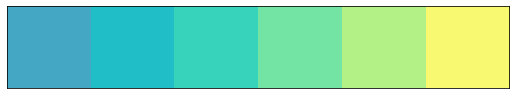

In [5]:
mpl.rcParams["font.size"] = 16

theme_colors = ["#44A7C4", "#20BEC7", "#38D3BB", "#73E4A3", "#B3F186", "#F9F871"]
theme_palette = sns.set_palette(sns.color_palette(theme_colors))

sns.palplot(sns.color_palette(theme_colors), size=1.5)
plt.tick_params(axis="both", labelsize=0, length=0)

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Create a personal library of reusable functions

In [6]:
def read_data(path, analyze=True):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print("=== Shape of Data ===")
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print("\n=== Train Data: First 5 Rows ===\n")
        display(train.head())
        print("\n=== Train Column Names ===\n")
        display(train.columns)
        print("\n=== Features/Explanatory Variables ===\n")
        eval_features(train)
        print("\n === Skewness ===\n")
        check_skew(train)
        print("\n === Kurtosis ===\n")
        check_kurtosis(train)
    return train, test, submission_df


def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df


def show_fold_scores(scores):
    cv_score = np.mean(scores)  # Used in filename
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )


def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = preprocessing.LabelEncoder().fit_transform(train[col])
        test[col] = preprocessing.LabelEncoder().fit_transform(test[col])
    return train, test

In [7]:
# Save OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">EDA Library</h1>
</div>

Functions specific to an EDA kernel

In [8]:
def show_missing_features(df):
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])


def show_duplicate_records(df):
    dups = df.duplicated()
    print(dups.sum())


def eval_features(df):
    ## Separate Categorical and Numerical Features
    categorical_features = list(
        df.select_dtypes(include=["category", "object"]).columns
    )
    continuous_features = list(df.select_dtypes(include=["number"]).columns)

    print(f"Continuous features: {continuous_features}")
    print(f"Categorical features: {categorical_features}")
    print("\n --- Cardinality of Categorical Features ---\n")

    for feature in categorical_features:
        cardinality = df[feature].nunique()
        if cardinality < 10:
            print(f"{feature}: cardinality={cardinality}, {df[feature].unique()}")
        else:
            print(f"{feature}: cardinality={cardinality}")
    all_features = categorical_features + continuous_features
    return all_features, categorical_features, continuous_features


def show_feature_importance(feature_importance_lst):
    fis_df = pd.concat(feature_importance_lst, axis=1)

    fis_df.sort_values("0_importance", ascending=True).head(40).plot(
        kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
    )
    plt.show()


def show_feature_target_crosstab(df, feature_lst, target):
    for feature in feature_lst:
        print(f"\n=== {feature} vs {target} ===\n")
        display(
            pd.crosstab(df[feature], df[target], margins=True)
        )  # display keeps bold formatting


def show_cardinality(df, features):
    print("=== Cardinality ===")
    print(df[features].nunique())


def show_unique_features(df, features):
    for col in features:
        print(col, sorted(df[col].dropna().unique()))


def feature_distribution_types(df, display=True):
    continuous_features = list(
        df.select_dtypes(include=["int64", "float64", "uint8"]).columns
    )
    categorical_features = list(df.select_dtypes(include=["object", "bool"]).columns)
    if display:
        print(f"Continuous Features={continuous_features}\n")
        print(f"Categorical Features={categorical_features}")
    return continuous_features, categorical_features


def summary_statistics(X, enhanced=True):
    desc = X.describe()
    if enhanced:
        desc.loc["var"] = X.var(numeric_only=True).tolist()
        desc.loc["skew"] = X.skew(numeric_only=True).tolist()
        desc.loc["kurt"] = X.kurtosis(numeric_only=True).tolist()

    with pd.option_context("display.precision", 2):
        style = desc.transpose().style.background_gradient(
            cmap="coolwarm"
        )  # .set_precision(4)
    display(style)


def check_skew(df):
    skew = df.skew(skipna=True, numeric_only=True).sort_values(ascending=False)
    print(skew)


def check_kurtosis(df):
    kurtosis = df.kurtosis(skipna=True, numeric_only=True).sort_values(ascending=False)
    print(kurtosis)


def missing_values(df):
    missing_percent = df.isnull().sum() * 100 / df.shape[0]
    df_missing_percent = pd.DataFrame(missing_percent).round(2)
    df_missing_percent = df_missing_percent.reset_index().rename(
        columns={"index": "Feature", 0: "Missing Percentage (%)"}
    )
    df_missing_value = df.isnull().sum()
    df_missing_value = df_missing_value.reset_index().rename(
        columns={"index": "Feature", 0: "Missing Values"}
    )

    final = df_missing_value.merge(
        df_missing_percent, how="inner", left_on="Feature", right_on="Feature"
    )
    final = final.sort_values(by="Missing Percentage (%)", ascending=False)
    return final


def show_missing_features_pct(df):
    nan = pd.DataFrame(
        df.isna().sum().sort_values(ascending=False), columns=["NaN_sum"]
    )
    nan["Percentage(%)"] = (nan["NaN_sum"] / len(df)) * 100
    nan = nan[nan["NaN_sum"] > 0]
    nan = nan.sort_values(by=["NaN_sum"], ascending=False)
    display(nan)

In [9]:
def check_low_cardinality(df, features, threshold=25):
    low_cardinality = [col for col in features if df[col].nunique() < threshold]
    return low_cardinality

In [10]:
# OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data and Analyze</h1>
</div>

Support datatable for large datasets.
Using datatable is described in [Tutorial on reading datasets](https://www.kaggle.com/hiro5299834/tutorial-on-reading-datasets)

In [11]:
%%time
train, test, submission_df = read_data(Config.path, analyze=True)

=== Shape of Data ===
 train data: Rows=8693, Columns=14
 test data : Rows=4277, Columns=13

=== Train Data: First 5 Rows ===



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



=== Train Column Names ===



Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


=== Features/Explanatory Variables ===

Continuous features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical features: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

 --- Cardinality of Categorical Features ---

PassengerId: cardinality=8693
HomePlanet: cardinality=3, ['Europa' 'Earth' 'Mars' nan]
CryoSleep: cardinality=2, [False True nan]
Cabin: cardinality=6560
Destination: cardinality=3, ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP: cardinality=2, [False True nan]
Name: cardinality=8473

 === Skewness ===

ShoppingMall    12.627562
VRDeck           7.819732
Spa              7.636020
FoodCourt        7.102228
RoomService      6.333014
Age              0.419097
Transported     -0.014497
dtype: float64

 === Kurtosis ===

ShoppingMall    328.870913
VRDeck           86.011186
Spa              81.202110
FoodCourt        73.307230
RoomService      65.273802
Age               0.101933
Transported      -2.000250


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [13]:
train[TARGET].unique()

array([False,  True])

- [Essential Techniques to Style Pandas DataFrames](https://www.kaggle.com/code/iamleonie/essential-techniques-to-style-pandas-dataframes)

In [14]:
summary_statistics(train, enhanced=False)

,count,mean,std,min,25%,50%,75%,max
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00


In [15]:
train.describe(include=["float64"]).T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [16]:
# features with object and bool types
train.describe(include=[object, bool]).T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2
Transported,8693,2,True,4378


In [17]:
corr = train.corr()
corr.style.background_gradient(cmap="coolwarm")

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


## Encode Categorical Features

In [18]:
train[TARGET] = train[TARGET].replace({True: 1, False: 0})
train["VIP"] = train["VIP"].replace({True: 1, False: 0})  # .astype(int)
train["CryoSleep"] = train["CryoSleep"].replace({True: 1, False: 0})  # .astype(int)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [19]:
continuous_features = train.select_dtypes(include=[np.number]).columns
continuous_features = list(train.select_dtypes(include=["number"]).columns)


continuous_features  # returns all the columns name

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported']

## PairPlot

Can be slow so we often disable during development

In [20]:
%%time
# X = train[continuous_features].copy()
# sns.pairplot(data=train[continuous_features], hue=TARGET, height=3, diag_kind="hist", palette=theme_palette)
# sns.pairplot(train, height=3, diag_kind="hist")
# plt.show()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Preprocessing</h1>
</div>

### Missing Values

- https://www.kaggle.com/code/hamzaghanmi/let-s-use-keras-tensorflow

<AxesSubplot:>

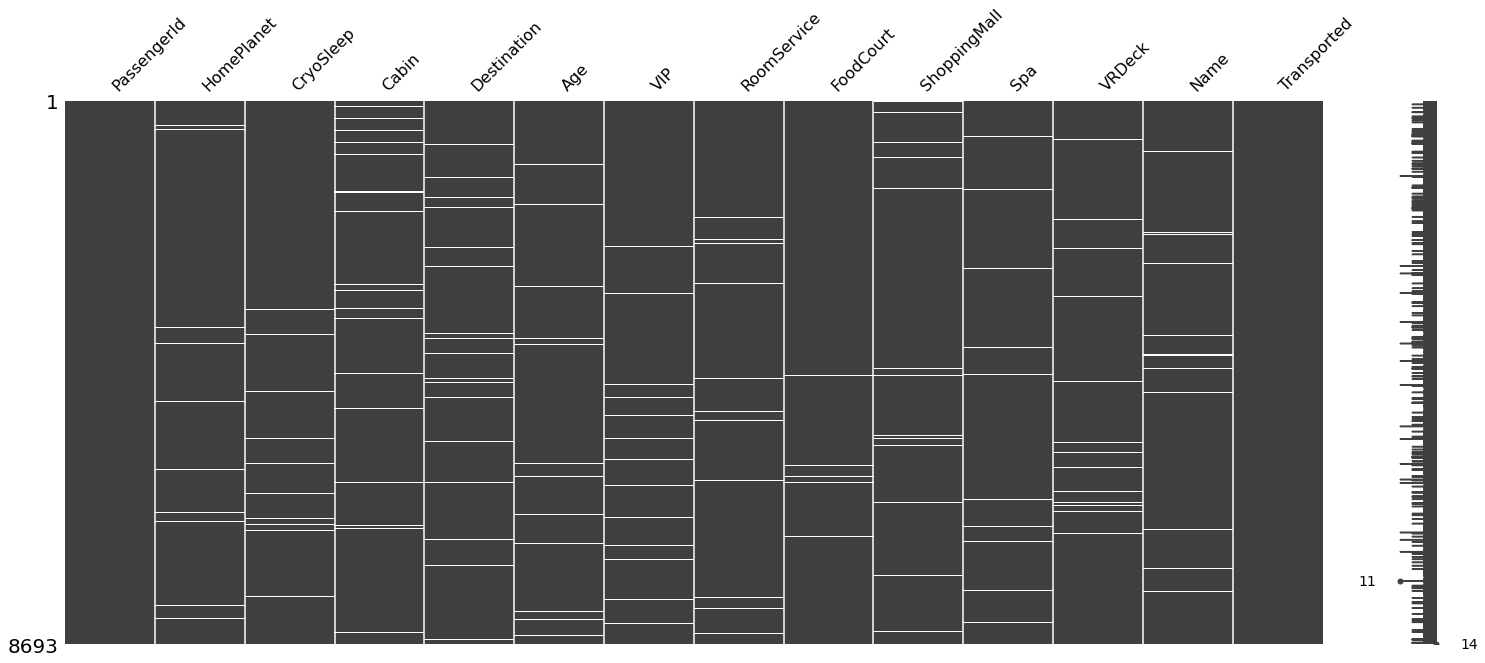

In [21]:
msno.matrix(train)

In [22]:
show_missing_features(train)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64


In [23]:
show_missing_features_pct(train)

,NaN_sum,Percentage(%)
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


- https://www.kaggle.com/code/shilongzhuang/space-titanic-a-beginner-guide-80-24-accuracy

In [24]:
## Separate Categorical and Numerical Features
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)
cat_features.remove("PassengerId")

In [25]:
print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")

Categorical Features: ['HomePlanet', 'Cabin', 'Destination', 'Name']
Numerical Features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [26]:
_ = feature_distribution_types(train)

Continuous Features=['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']

Categorical Features=['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name']


In [27]:
train[cat_features].nunique()

HomePlanet        3
Cabin          6560
Destination       3
Name           8473
dtype: int64

In [28]:
train = train.drop(columns=["Name", "Cabin"], axis=1).copy()
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
cat_features.remove("PassengerId")

In [29]:
train[num_features].nunique()

Age               80
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
dtype: int64

In [30]:
show_cardinality(train, num_features)

=== Cardinality ===
Age               80
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
dtype: int64


In [31]:
## Double check cardinality or numerical features.  Could be categorical features
cat_col = [col for col in num_features if train[col].nunique() < 25]
cat_col

[]

In [32]:
check_low_cardinality(train, cat_features, 25)

['HomePlanet', 'Destination']

In [33]:
FEATURES = cat_features + num_features
FEATURES

['HomePlanet',
 'Destination',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [34]:
train = create_folds(train, TARGET, Config.N_FOLDS)

TARGET=Transported, n_folds=5, seed=42


In [35]:
cat_features

['HomePlanet', 'Destination']

In [36]:
train, test = label_encoder(
    train, test, ["Destination", "CryoSleep", "VIP", "HomePlanet"]
)
# X_test = pd.get_dummies(test[FEATURES], drop_first=True)

<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Model with Cross Validation</h1>
</div>

In [37]:
from scipy.stats import mode


def merge_test_predictions(final_test_predictions, calc_probability=True):
    """
    Take the fold test predictions and combine either by averaging or taking the mode.
    """
    if Config.calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result

In [38]:
def train_xgb_model(
    df,
    test,
    get_model_fn,
    FEATURES,
    TARGET,
    calc_probability,
    rowid,
    params,
    n_folds=5,
    seed=42,
):

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = (
            xvalid.PassengerId.values.tolist()
        )  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]
        xtrain.head()
        #         print(f"{yvalid}")
        model = get_model_fn(params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=False,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)

        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        fold_score = metrics.accuracy_score(
            yvalid, preds_valid_class
        )  # Validation Set Score
        #         fold_score = metrics.roc_auc_score(yvalid, preds_valid)  # Validation Set Score

        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Accuracy: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )

In [39]:
xgb_params = {
    "enable_categorical": True,
    "objective": "binary:logistic",
    "eval_metric": "logloss",  # auc
    "n_estimators": Config.N_ESTIMATORS,
    "learning_rate": 0.021138659045230178,
    "subsample": 0.4,
    "colsample_bytree": 0.91,
    "max_depth": 17,
    "gamma": 0.6000000000000001,
    "booster": "gbtree",
    "tree_method": "hist",
    "reg_lambda": 0.005882742898970815,
    "reg_alpha": 0.0014501578157205654,
    "random_state": 42,
    "n_jobs": 4,
    "min_child_weight": 5.567082153821453,
}

In [40]:
def get_xgb_clf_model(params):
    #     model = xgb.XGBClassifier(n_estimators=1000)
    model = xgb.XGBClassifier(**params)
    return model

In [41]:
model_name = "xgb1"  # Make the code more generic

In [42]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train,
    test,
    get_xgb_clf_model,
    FEATURES,
    TARGET,
    Config.calc_probability,
    "PassengerId",
    xgb_params,
    Config.N_FOLDS,
    Config.seed,
)

========== Fold 1/5 ==========
fold: 1, Accuracy: 0.8073605520414031, Run Time: 0.72
========== Fold 2/5 ==========
fold: 2, Accuracy: 0.780333525014376, Run Time: 0.77
========== Fold 3/5 ==========
fold: 3, Accuracy: 0.8039102932719954, Run Time: 0.70
========== Fold 4/5 ==========
fold: 4, Accuracy: 0.7968929804372842, Run Time: 0.69
========== Fold 5/5 ==========
fold: 5, Accuracy: 0.7859608745684695, Run Time: 1.23


In [43]:
show_fold_scores(fold_scores)

Scores -> Adjusted: 0.78457164 , mean: 0.79489165, std: 0.01032001


In [44]:
result = merge_test_predictions(final_test_predictions, Config.calc_probability)
result[:20]

Mean


array([0.6103889 , 0.10169576, 0.9261349 , 0.86229765, 0.4872628 ,
       0.6241306 , 0.9300183 , 0.8921191 , 0.9280965 , 0.65445065,
       0.21236745, 0.19970067, 0.6974368 , 0.8508558 , 0.11652981,
       0.15113923, 0.20277461, 0.8941196 , 0.82147133, 0.14874843],
      dtype=float32)

In [45]:
submission_df = test[["PassengerId"]].copy()
submission_df

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [46]:
submission_df[TARGET] = result
submission_df.head(10)

,PassengerId,Transported
0,0013_01,0.610389
1,0018_01,0.101696
2,0019_01,0.926135
3,0021_01,0.862298
4,0023_01,0.487263
5,0027_01,0.624131
6,0029_01,0.930018
7,0032_01,0.892119
8,0032_02,0.928096
9,0033_01,0.654451


<div style="background-color:rgba(68, 167, 196, 0.9);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Submission</h1>
</div>

In [47]:
submission_df[TARGET] = np.rint(submission_df[TARGET]).astype(bool)
submission_df.to_csv(f"submission.csv", index=False)
submission_df.head(10)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True
